## Matrix factorization via NN, contrasting MAE with surpriselib's baseline algos SVD, SVD++

In [1]:
import os
import numpy as np
import pandas as pd


data_path = os.path.expanduser('C:\\Users\\might\\Desktop\\jupyter notebooks\\u.data')

* #### original df containing all 100k data points

In [2]:
df = pd.read_csv(data_path, sep='\t', header=None)
df[2]= df[2].apply(lambda x: int(x>3))#since in df, no. vals holding 1 ratings:6110, 2 ratings:11370, 3 ratings:27145, 4 ratings:34174, 5 ratings: 21201 
df.head(5)#Therefore all ratings(55375) of 4,5 squished to 1 & all ratings(44625) of 1,2,3 are squished to 0

,0,1,2,3
0,196,242,0,881250949
1,186,302,0,891717742
2,22,377,0,878887116
3,244,51,0,880606923
4,166,346,0,886397596


In [3]:
shuffled_df = df.loc[np.random.randint(0, 100000, size=df.shape[0])]

#sm_train_df = shuffled_df[:80000]#small dataframe, trimming data points to random 2000 datapoints
#test_df= shuffled_df[-20000:]

#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)
print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


* ### Training & testing results with SVD from surpriselib
    * Using same dataframes for all three
    * n_factors= 100, epochs= 64

In [4]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

from surprise.model_selection import train_test_split

rdr = Reader(rating_scale=(0,1))
#train_data = Dataset.load_from_df(sm_train_df[[0,1,2]], reader= rdr)
data = Dataset.load_from_df(shuffled_df[[0,1,2]], reader= rdr)

#trainset = train_data.build_full_trainset()#contains 80k data points

trainset, testset = train_test_split(data, test_size=0.2)
#both trainset & testset have their ratings value swapped from 1 in place of 0; and 2 in place of 1

#test_data= Dataset.load_from_df(test_df[[0,1,2]], reader= rdr)
#testset = test_data.build_full_trainset().build_testset()#testset for surprise.SVD

In [5]:
from surprise import accuracy
import time

t1= time.time()

algo_svd = SVD(n_factors=100, n_epochs=64)

algo_svd.fit(trainset)

print('training time:', time.time()-t1)

training time: 11.896177053451538


In [6]:
pred = algo_svd.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse: {}, mae: {}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3503
MAE:  0.2747

Test results on 80k training data & 20k test data -- rmse: 0.3502859975580892, mae: 0.274662635822328


* #### ROC Curve

In [7]:
pred_arr= pd.DataFrame(pred)
pred_arr.head(7)

,uid,iid,r_ui,est,details
0,786,66,1.0,0.650279,{'was_impossible': False}
1,537,44,0.0,0.239054,{'was_impossible': False}
2,660,208,1.0,0.619494,{'was_impossible': False}
3,181,619,0.0,0.186057,{'was_impossible': False}
4,486,257,0.0,0.551675,{'was_impossible': False}
5,916,427,1.0,0.891885,{'was_impossible': False}
6,916,748,0.0,0.172283,{'was_impossible': False}


In [8]:
y_true = np.array(pred_arr['r_ui'])
y_scores = np.array(pred_arr['est'])

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
roc_auc= auc(fpr, tpr)

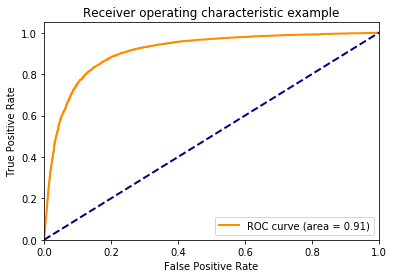

In [10]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* #### Precision-Recall Curve

In [11]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores, pos_label=1)


In [12]:
from inspect import signature

from sklearn.metrics import average_precision_score

avg_precision = average_precision_score(y_true, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(avg_precision))

Average precision-recall score: 0.91


Text(0.5, 1.0, 'User-Movie-rating Precision-Recall curve: AP=0.91')

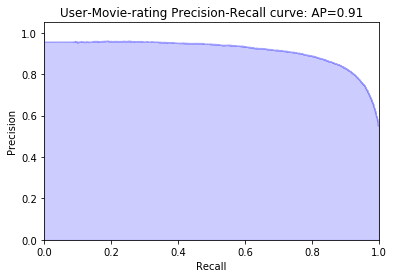

In [13]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('User-Movie-rating Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))

* #### Creating confusion matrix

In [14]:
pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))
pred_arr.head(7)

,uid,iid,r_ui,est,details
0,786,66,1.0,1.0,{'was_impossible': False}
1,537,44,0.0,0.0,{'was_impossible': False}
2,660,208,1.0,1.0,{'was_impossible': False}
3,181,619,0.0,0.0,{'was_impossible': False}
4,486,257,0.0,1.0,{'was_impossible': False}
5,916,427,1.0,1.0,{'was_impossible': False}
6,916,748,0.0,0.0,{'was_impossible': False}


In [15]:
pred_arr= np.asarray(pred_arr)
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]

9691

In [16]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]

7211

In [17]:
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]

1330

In [18]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]

1768

In [19]:
def confusion_matrix(pred):
    pred_arr= pd.DataFrame(pred)
    pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))#changing prediction values to just 0s & 1s
    pred_arr= np.asarray(pred_arr)[:,:4]#contains first 4 cols of pred array, removing timestamp
    
    conf_df = pd.DataFrame(index=['True rating 1', 'True rating 0'], columns=['Estimated rating 1', 'Estimated rating 0'])
    
    conf_df['Estimated rating 1']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]#True Positives, 9526
    conf_df['Estimated rating 0']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]#True Negatives, 6822
    conf_df['Estimated rating 0']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]#False Negatives, 1470
    conf_df['Estimated rating 1']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]#False Positives, 2182
    
    return np.asarray(conf_df), conf_df

In [20]:
confusion_mat, confusion_df = confusion_matrix(pred)
confusion_df

,Estimated rating 1,Estimated rating 0
True rating 1,9691,1330
True rating 0,1768,7211


In [21]:
print(confusion_mat)

[[9691 1330]
 [1768 7211]]


* ### Training & testing results with SVD++ from surpirselib
    * Using same dataframes for both
    * n_factors= 100, epochs= 40

In [46]:
from surprise import SVDpp

t1= time.time()

algo_svdpp = SVDpp(n_factors=100, n_epochs=40)

algo_svdpp.fit(trainset)

print('training time:', time.time()-t1)


training time: 775.9093706607819


In [47]:
pred = algo_svdpp.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse:{}, mae:{}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3543
MAE:  0.2791

Test results on 80k training data & 20k test data -- rmse:0.35433296400534825, mae:0.2791093764734291


* ### Training & testing results with matrix factorization implemented with NN
    * Using same dataframes as above
    * Latent vector (k) size : 100, epochs =64

In [22]:
#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)

print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


In [23]:
shuffled_df.head(5)

,0,1,2,3
63197,664,302,1,876523093
60431,815,132,1,878695278
81084,922,153,1,891451037
93333,857,328,0,883432301
16148,375,566,1,886621985


In [24]:
print('max value of user id:', max(shuffled_df[0]),'\nmax value of movie id:', max(shuffled_df[1]),'\nTherefore concatenated shape of input layer:',(max(shuffled_df[0])+max(shuffled_df[1]),))

max value of user id: 943 
max value of movie id: 1682 
Therefore concatenated shape of input layer: (2625,)


In [25]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.


In [26]:
x_train_user_in = to_categorical(shuffled_df[0])#contains the one-hot encoded user_id data, shaped (batch_size, max(sm_df[0]))
x_train_movie_in = to_categorical(shuffled_df[1])#contains the one-hot encoded movie_id data, shaped (batch_size, max(sm_df[1]))

y_ratings= shuffled_df[2]
print('shape of x_train_user_in:', x_train_user_in.shape,'\nshape of x_train_movie_in:', x_train_movie_in.shape,
      '\nshape of x_train_user_in:',y_ratings.shape)

shape of x_train_user_in: (100000, 944) 
shape of x_train_movie_in: (100000, 1683) 
shape of x_train_user_in: (100000,)


In [27]:
user_in_layer = Input(shape=(max(shuffled_df[0])+1,))#top half of input layer,+1 to accomodate on-hot encoded vectors
movie_in_layer = Input(shape=(max(shuffled_df[1])+1,))#bottom half of input layer

#total input moves as concatenated user_id & movie_id one-hot encoded forms

hid_layer_u = Dense(100)(user_in_layer)#latent dimension k=100 for user_id #_Embedding(100, )
hid_layer_m= Dense(100)(movie_in_layer)#latent dimension k=100 for movie_id

merge_layer = keras.layers.dot([hid_layer_u, hid_layer_m], axes=1)



predictions = Dense(1, activation='sigmoid')(merge_layer)

model = Model(inputs=[user_in_layer, movie_in_layer], outputs= predictions)

model.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 944)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1683)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          94500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          168400      input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [29]:
from keras.callbacks import ModelCheckpoint

checkpoints = ModelCheckpoint('./NN_m_factorization_weights.{epoch:02}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', period=2)

In [30]:
history = model.fit([x_train_user_in, x_train_movie_in], y_ratings, verbose=1, epochs=64, batch_size=32, validation_split=0.2, callbacks=[checkpoints])

Train on 80000 samples, validate on 20000 samples
Epoch 1/64
80000/80000 [==============================] - 6s 70us/step - loss: 0.6880 - mean_absolute_error: 0.4953 - acc: 0.5514 - val_loss: 0.6869 - val_mean_absolute_error: 0.4945 - val_acc: 0.5538
Epoch 2/64
80000/80000 [==============================] - 5s 65us/step - loss: 0.6870 - mean_absolute_error: 0.4942 - acc: 0.5521 - val_loss: 0.6863 - val_mean_absolute_error: 0.4939 - val_acc: 0.5538

Epoch 00002: val_loss improved from inf to 0.68626, saving model to ./NN_m_factorization_weights.02-0.69.hdf5
Epoch 3/64
80000/80000 [==============================] - 5s 67us/step - loss: 0.6862 - mean_absolute_error: 0.4939 - acc: 0.5521 - val_loss: 0.6855 - val_mean_absolute_error: 0.4932 - val_acc: 0.5538
Epoch 4/64
80000/80000 [==============================] - 5s 68us/step - loss: 0.6852 - mean_absolute_error: 0.4932 - acc: 0.5521 - val_loss: 0.6842 - val_mean_absolute_error: 0.4926 - val_acc: 0.5538

Epoch 00004: val_loss improved fro

80000/80000 [==============================] - 5s 66us/step - loss: 0.5194 - mean_absolute_error: 0.3493 - acc: 0.7441 - val_loss: 0.5400 - val_mean_absolute_error: 0.3593 - val_acc: 0.7288
Epoch 34/64
80000/80000 [==============================] - 6s 70us/step - loss: 0.5181 - mean_absolute_error: 0.3487 - acc: 0.7442 - val_loss: 0.5400 - val_mean_absolute_error: 0.3566 - val_acc: 0.7308

Epoch 00034: val_loss improved from 0.54036 to 0.53997, saving model to ./NN_m_factorization_weights.34-0.54.hdf5
Epoch 35/64
80000/80000 [==============================] - 5s 66us/step - loss: 0.5168 - mean_absolute_error: 0.3478 - acc: 0.7455 - val_loss: 0.5390 - val_mean_absolute_error: 0.3580 - val_acc: 0.7292
Epoch 36/64
80000/80000 [==============================] - 6s 79us/step - loss: 0.5164 - mean_absolute_error: 0.3476 - acc: 0.7458 - val_loss: 0.5394 - val_mean_absolute_error: 0.3593 - val_acc: 0.7292

Epoch 00036: val_loss improved from 0.53997 to 0.53935, saving model to ./NN_m_factoriza

In [31]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])

* #### Training and Valdiation plots

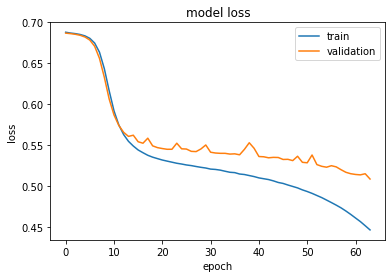

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')

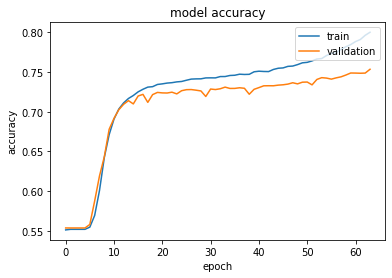

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train', 'validation'], loc= 'upper right')

### Testing with individual cases

In [36]:
testcase = testset[np.random.randint(len(testset))]
print(testcase)

(655, 11, 1.0)


• **With SVD**

In [37]:
# int(testcase[2]>1) ;  because testset contains labels 0 in original df as 1 & 1 as 2
print('\nPredictions with SVD :\n', algo_svd.predict(testcase[0], testcase[1], int(testcase[2]>1), verbose=True))

user: 655        item: 11         r_ui = 0.00   est = 0.37   {'was_impossible': False}

Predictions with SVD :
 user: 655        item: 11         r_ui = 0.00   est = 0.37   {'was_impossible': False}


• **With SVD++** (Haven't retrained it for epochs=64)

In [54]:
print('\nPredictions with SVD++:\n', algo_svdpp.predict(testcase[0], testcase[1], testcase[2], verbose=True))

user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}

Predictions with SVD++:
 user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}


• **With NN factorization**

In [38]:
print('NN input layers shape requirement:\n')
model.input

NN input layers shape requirement:



[<tf.Tensor 'input_1:0' shape=(?, 944) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 1683) dtype=float32>]

In [39]:
u_id = to_categorical(testcase[0], num_classes=int(model.input[0].shape[1]))
u_id= u_id.reshape((1,u_id.shape[0]))

item_id = to_categorical(testcase[1], num_classes=int(model.input[1].shape[1]))
item_id= item_id.reshape((1,item_id.shape[0]))

print('\nPredictions with NN matrix factorization:\n', model.predict(x= [u_id, item_id], verbose=True))

1/1 [==============================] - 0s 11ms/step

Predictions with NN matrix factorization:
 [[0.32776472]]


### Latent vector visualizations
* #### Latent vectors from NN factorization

In [40]:
#taking 100 datapoints from surprise testset to project similarity metric b/w latent vectors from NN_fact Vs. SVD
testset_arr= np.asarray(testset[:150])
print(testset_arr[:5])

[[786.  66.   2.]
 [537.  44.   1.]
 [660. 208.   2.]
 [181. 619.   1.]
 [486. 257.   1.]]


In [41]:
from keras.utils import to_categorical
#converting inputs to sparse rep
tset_user_nn = to_categorical(testset_arr[:,0], num_classes=int(model.input[0].shape[1]))
tset_mov_nn = to_categorical(testset_arr[:,1], num_classes=int(model.input[1].shape[1]))
print('shape of tset_user_nn: {}\nshape of tset_mov_nn: {}'.format(tset_user_nn.shape, tset_mov_nn.shape))

shape of tset_user_nn: (150, 944)
shape of tset_mov_nn: (150, 1683)


* Following are the **latent weight vectors for layer 'dense_1' and 'dense_2'**

In [42]:
user_wt_vec = model.layers[2].get_weights()
mov_wt_vec = model.layers[3].get_weights()

print('shape of dense_1 layer weight vector: {}\nshape of dense_2 layer weight vectors: {}'.format(user_wt_vec[0].shape, mov_wt_vec[0].shape))

shape of dense_1 layer weight vector: (944, 100)
shape of dense_2 layer weight vectors: (1683, 100)


* Following are the **forward computed latent vectors** for 100 (ui, mi) pairs testcases-- which is a result of dot between **[test_user], [user_wt_vec]** and **[test_mov] & [mov_wt_vec]** from above two cells

In [43]:
from keras import backend as K

output_dense1 = K.function([model.layers[0].input], [model.layers[2].output])
output_dense2 = K.function([model.layers[1].input], [model.layers[3].output])

In [44]:
latent_vec_user_nn = output_dense1([tset_user_nn])
latent_vec_mov_nn = output_dense2([tset_mov_nn])

print('shape of latent output vectors from NN:', latent_vec_user_nn[0].shape)

shape of latent output vectors from NN: (150, 100)


* ### Latent vectors from SVD

* pu = SVD's learned User vectors
* qi = SVD's learned Item vectors

In [45]:
user_vec_svd = algo_svd.pu #pu: user factors
item_vec_svd = algo_svd.qi# qi movie factors

print('shape of internal user_factors vectors in svd: {}\nshape of internal item_factors vectors in svd: {}'.format(user_vec_svd.shape, item_vec_svd.shape))

shape of internal user_factors vectors in svd: (943, 100)
shape of internal item_factors vectors in svd: (1599, 100)


In [47]:
tset_user_svd= to_categorical(testset_arr[:,0], num_classes=int(user_vec_svd.shape[0]))#testset_arr[:,0]
tset_mov_svd= to_categorical(testset_arr[:,1], num_classes=int(item_vec_svd.shape[0]))

print('shape of tset_user_svd: {}\nshape of tset_mov_svd: {}'.format(tset_user_svd.shape, tset_mov_svd.shape))

shape of tset_user_svd: (150, 943)
shape of tset_mov_svd: (150, 1599)


In [48]:
latent_vec_user_svd = np.dot(tset_user_svd, user_vec_svd)
latent_vec_mov_svd = np.dot(tset_mov_svd, item_vec_svd)

print('shape of latent output vectors from SVD:', latent_vec_user_svd.shape)

shape of latent output vectors from SVD: (150, 100)


* ### Obtaining Cosine similarity between:

    1. latent user vectors from NN & SVD, i.e **[latent_vec_user_nn] & [latent_vec_user_svd]**
    2. latent user vectors from NN & SVD, i.e **[latent_vec_mov_nn] & [latent_vec_mov_svd]**

In [49]:
print('affirming the shapes: \n\nshape of latent_vec_user_nn: {} VS. Shape of latent_vec_user_svd: {} \n\nshape of latent_vec_mov_nn: {} VS. Shape of latent_vec_mov_svd: {} '.format(
    latent_vec_user_nn[0].shape, latent_vec_user_svd.shape, latent_vec_mov_nn[0].shape, latent_vec_mov_svd.shape ))

affirming the shapes: 

shape of latent_vec_user_nn: (150, 100) VS. Shape of latent_vec_user_svd: (150, 100) 

shape of latent_vec_mov_nn: (150, 100) VS. Shape of latent_vec_mov_svd: (150, 100) 


In [50]:
print('number of testset datapoints evaulated for similarity: ', testset_arr.shape[0])#test array vector used for latent rep.

number of testset datapoints evaulated for similarity:  150


In [51]:
from sklearn.metrics.pairwise import cosine_similarity

sim_user_vec= list()
sim_mov_vec= list()
num_testcases= testset_arr.shape[0]#i.e.,150 datapoints
#Following contains the vector of similarity value of representation from NN & SVD for 150 users, i.e.,
# sim_user_vec[0]= [user_1 latent representation from NN Vs. user_1 latent representation from SVD]
# sim_user_vec[1]= [user_2 latent representation from NN Vs. user_2 latent representation from SVD]


for i in range(num_testcases):#for 150 testset cases
    sim_user_vec.append(cosine_similarity(latent_vec_user_nn[0][i].reshape(1,-1), latent_vec_user_svd[i].reshape(1,-1)))
    sim_mov_vec.append(cosine_similarity(latent_vec_mov_nn[0][i].reshape(1,-1), latent_vec_mov_svd[i].reshape(1,-1)))

sim_user_vec= np.array(sim_user_vec).reshape(num_testcases)#converting to numpy array & reshaping to (150,)
sim_mov_vec= np.array(sim_mov_vec).reshape(num_testcases)#converting to numpy array & reshaping to (150,)
print('Shape of sim_user_vec : {} \nShape of sim_mov_vec: {}'.format(sim_user_vec.shape, sim_mov_vec.shape))

Shape of sim_user_vec : (150,) 
Shape of sim_mov_vec: (150,)


* ### Scatter-plot Visualizations

In [52]:
import matplotlib.pyplot as plt

d1 = (np.array(range(1, num_testcases+1)), sim_user_vec)#holds (user_id, corresponding_latent_user_vec_representation)
d2 = (np.array(range(1, num_testcases+1)), sim_mov_vec)#holds (movie_id, corresponding_latent_movie_vec_representation)
data = (d1, d2)
colors = ("red", "blue")
groups = ("user_vec_similarity", "mov_vec_similarity")

* Solo User vector similarity plot

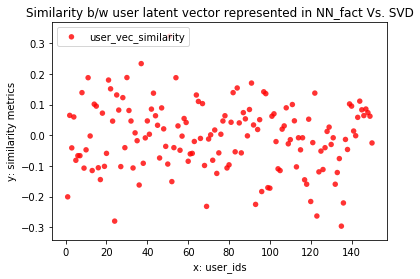

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1 #plotting only user_similary_vector
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('Similarity b/w user latent vector represented in NN_fact Vs. SVD')
plt.xlabel('x: user_ids')
plt.ylabel('y: similarity metrics')
plt.legend(loc=2)
plt.show()

* Solo movie vector similarity plot

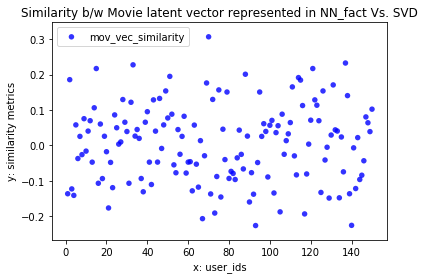

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d2 #plotting only movie_similary_vector
ax.scatter(x, y, alpha=0.8, c=colors[1], edgecolors='none', s=30, label=groups[1])
plt.title('Similarity b/w Movie latent vector represented in NN_fact Vs. SVD')
plt.xlabel('x: user_ids')
plt.ylabel('y: similarity metrics')
plt.legend(loc=2)
plt.show()

* Combined User and Movie vector similarity plot

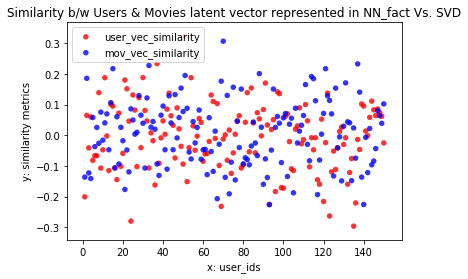

In [55]:
data = (d1, d2)
colors = ("red", "blue")
groups = ("user_vec_similarity", "mov_vec_similarity")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)#, axisbg="1.0")

for data, color, group in zip(data, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w Users & Movies latent vector represented in NN_fact Vs. SVD')
plt.xlabel('x: user_ids')
plt.ylabel('y: similarity metrics')
plt.legend(loc=2)
plt.show()

* #### Therefore with 80k training datapoints & 20k validation datapoints after 64 epochs:
    * MAE value with surprise SVD implementation: 0.2747
    * MAE value with surprise SVD++ implementation: 0.3563
    * MAE value after 40 epochs with matrix factorization with NN implementation: 0.3144
    



___________________